<a href="https://colab.research.google.com/github/user8391/Deep-Learning-/blob/main/Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regularization

Dropout Regularization

In [ ]:
# Importing libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [ ]:
# we drop units in each training epochs -> force their activation to 0 , to generalize the model
# Works best with 'not' enough data , and will not necessarily be directly needed with large data , as it is not prone to overfitting

# Defining a dropout instance to make some data
# probability for a neuron to be dropped out
probability = 0.5

dropout = nn.Dropout(p = probability) # default value of p is 0.5

x = torch.ones(10)

# Displaying what dropout returns
y = dropout(x)
print(x)
print(y) # output WITH the scaling
print(y*(1-probability)) # outputs with removing scaling
print(torch.mean(y))



tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([0., 2., 0., 2., 2., 0., 2., 0., 2., 2.])
tensor([0., 1., 0., 1., 1., 0., 1., 0., 1., 1.])
tensor(1.2000)


In [ ]:
# Dropout is turned off when evaluating the model
dropout.eval()
y = dropout(x)
print(y)

dropout.train()
y = dropout(x)
print(y)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([2., 0., 2., 0., 0., 2., 0., 0., 2., 0.])


In [ ]:
# BUT F.dropout() is not disabled in eval mode by default
dropout.eval()
y = F.dropout(x, training = True) # not an instance , part of functional , just a functional
# writing training = False
print(y)

tensor([0., 0., 2., 0., 0., 2., 2., 0., 2., 0.])


Droput regularization Implementation

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader , TensorDataset
from sklearn.model_selection import train_test_split

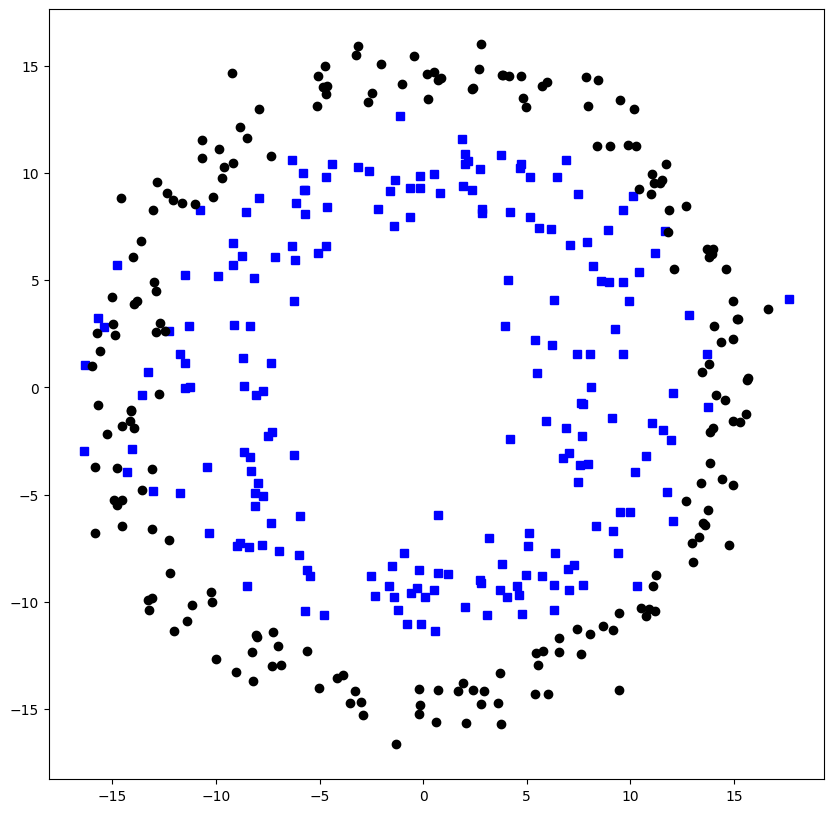

In [37]:
# Creating non Linearly seperable data
'''Note - seperation of The following data points might be best done by a simple non linear function where the distance
          from the centre is taken as a medium to seperate data , However , we still implement DL here'''

data_points = 200

# theeta
theta = np.linspace(0, np.pi*4 , data_points)
# radiuses
radius1 = 10
radius2 = 15

# data points
a = [radius1*np.cos(theta) + np.random.randn(data_points)*3 ,
     radius1*np.sin(theta) + np.random.randn(data_points) ]

b = [radius2*np.cos(theta) + np.random.randn(data_points) ,
     radius2*np.sin(theta) + np.random.randn(data_points) ]

labels_a = np.zeros(data_points)
labels_b = np.ones(data_points)

all_x = np.hstack((a[0], b[0]))
all_y = np.hstack((a[1], b[1]))

# 2. Stack them column-wise so each row is [x, y]
np_data = np.column_stack((all_x, all_y))

# 3. Combine labels into one flat array (400,)
np_labels = np.hstack((labels_a, labels_b))

# 4. Convert to tensors
data = torch.tensor(np_data).float()
labels = torch.tensor(np_labels).float().unsqueeze(1)

plt.figure(figsize = (10,10))

plt.plot(data[np.where(labels== 0)[0],0] , data[np.where(labels ==0)[0],1], 'bs')
plt.plot(data[np.where(labels== 1)[0],0] , data[np.where(labels ==1)[0],1], 'ko')

plt.show()


In [61]:
# Seperating data

x_train , x_test , y_train  , y_test = train_test_split(data,labels , train_size = 0.8)

# convert into pytorch datasets ( but already converted to tensors)
train_data = TensorDataset(x_train,y_train)
test_data = TensorDataset(x_test,y_test)

# Translate into dataloader objects
batch_size = 30 # hard coding is better here - explained later
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = True)

In [62]:
# Create the model

class Model(nn.Module):
  def __init__(self,dropoutRate):
     super().__init__()

     ## Layers
     self.input = nn.Linear(2,64)
     self.hidden = nn.Linear(64,64)
     self.output = nn.Linear(64,1)

     # parameters
     self.dr = dropoutRate

    # Forward prop
  def forward(self,x):
     x = self.input(x)
     x = F.dropout(x, p = self.dr , training = self.training) # self.training is a boolean , is true when model is in train mode and set to false if model is in eval mode
     x = F.relu(x)
     x = self.hidden(x)
     x = F.relu(x)
     x = F.dropout(x, p = self.dr , training = self.training)
     x = self.output(x)
     # no dropout here
     return x


In [63]:
# testing syntactical validity
temp = Model( 0.5)
data_temp = torch.randn(16,2)
print(temp(data_temp))

tensor([[-0.1531],
        [-0.0898],
        [ 0.3972],
        [ 0.5295],
        [-0.0849],
        [ 0.1036],
        [ 0.5679],
        [-0.1156],
        [-0.3425],
        [ 0.1952],
        [ 0.0452],
        [-0.1889],
        [ 0.1949],
        [ 0.4653],
        [ 0.3152],
        [ 0.3318]], grad_fn=<AddmmBackward0>)


In [64]:
# Model creation function
def createModel(dropout):
  ANN = Model(dropout)
  # loss function
  lossfn = nn.BCEWithLogitsLoss()
  # Optimizer (vanilla sgd) - we will learn better ones later
  optimizer = torch.optim.Adam(ANN.parameters(), lr = 0.01)
  return ANN , lossfn , optimizer

In [65]:
# Training function

numepochs = 1000

def trainModel(ANN , lossfn , optimizer):
  trainAcc = []
  testAcc = []

  for epoch in range(numepochs):

    batchAcc = []

    # Setting the mode to train
    ANN.train()
    for data, labels in train_loader:

      yHat = ANN(data)
      loss = lossfn(yHat, labels)


      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchAcc.append(100*torch.mean(((yHat > 0.5) == labels ).float()).item())
      # End of batch loop

    trainAcc.append(np.mean(batchAcc))

    # Evaluation mode
    ANN.eval()
    batchAcc = []
    X ,y = next(iter(test_loader))
    yHat = ANN(X)
    testAcc.append(100*torch.mean(((yHat > 0.5) == y ).float()).item())
    # End of training loop
  # Function output
  return trainAcc , testAcc

Test the model

In [66]:
dropout_rate = 0.0 # Vary and observe
ANN , lossfn , optimizer = createModel(dropout_rate)
trainAcc , testAcc = trainModel(ANN , lossfn , optimizer)

[]

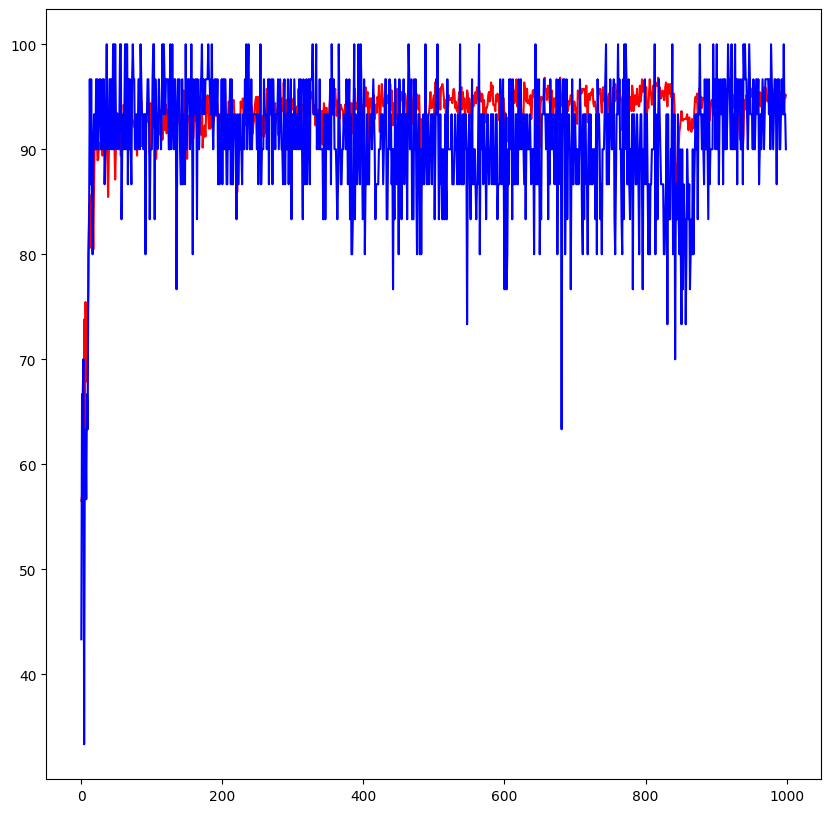

In [67]:
# Plot
plt.figure(figsize = (10,10))
plt.plot(trainAcc, label = 'Train', color = 'red')
plt.plot(testAcc, label = 'Test' , color = 'blue')
plt.plot()

# This chaotic scene depends on batch size , higher batch size will improve precesion

In [70]:
# 1D smoothing filter  to smooth visualization and not changing any data
def smooth(x , k = 8):
  return np.convolve(x, np.ones(k)/k, mode = 'same')

[]

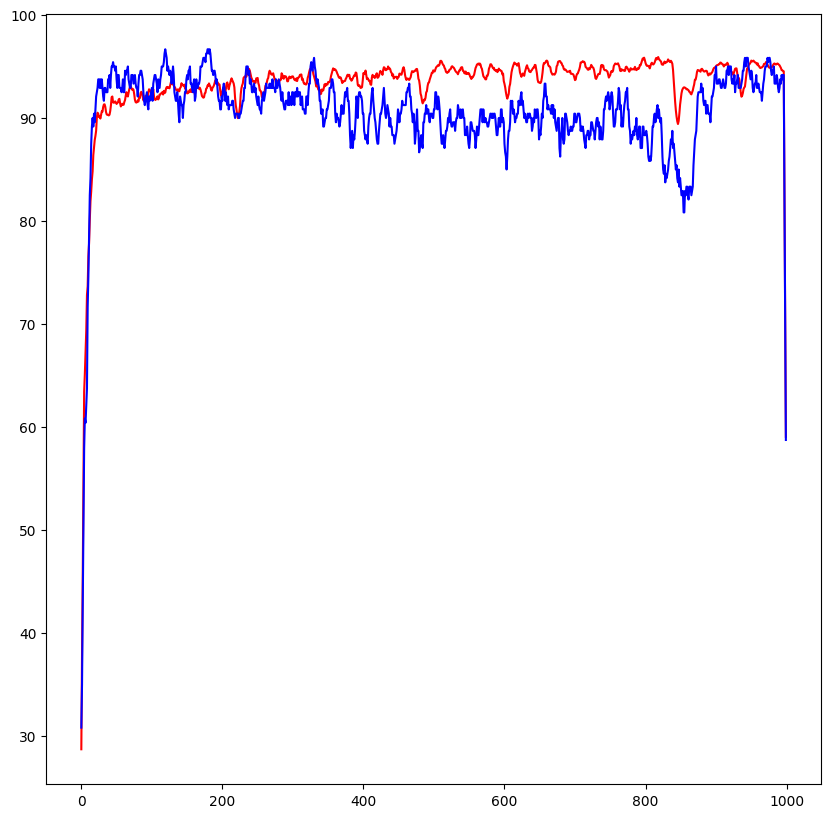

In [71]:
plt.figure(figsize = (10,10))
plt.plot(smooth(trainAcc), label = 'Train', color = 'red')
plt.plot(smooth(testAcc), label = 'Test' , color = 'blue')
plt.plot()

# Experiment - Varying Dropout Rates

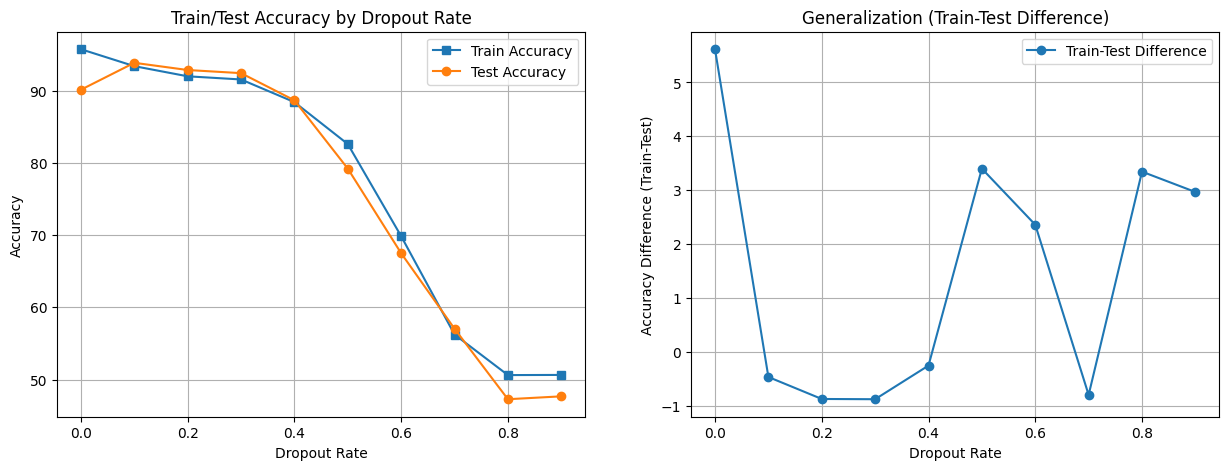

In [72]:
dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):

  # Creating and training the model
  model,lossfn,optimizer = createModel(dropoutRates[di])
  trainAcc , testAcc = trainModel(model,lossfn , optimizer)

  # Storing accuracies from last 100 epochs
  results[di,0] = np.mean(trainAcc[-100:])
  results[di,1] = np.mean(testAcc[-100:])

# Plot experiment results
fig , ax = plt.subplots(1,2,figsize = (15,5))

ax[0].plot(dropoutRates, results[:,0], 's-', label='Train Accuracy')
ax[0].plot(dropoutRates, results[:,1], 'o-', label='Test Accuracy')
ax[0].set_xlabel('Dropout Rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Train/Test Accuracy by Dropout Rate')
ax[0].legend()
ax[0].grid()

ax[1].plot(dropoutRates, results[:,0]-results[:,1], 'o-', label='Train-Test Difference')
ax[1].set_xlabel('Dropout Rate')
ax[1].set_ylabel('Accuracy Difference (Train-Test)')
ax[1].set_title('Generalization (Train-Test Difference)')
ax[1].legend()
ax[1].grid()

plt.show()

# Here if train-test accuracy difference is high , the model is OVERFITTING on training data , ideally we want it to be around 0
# as the dropout rate uncreares , both train and test performance goes down